# Foundations in Neuroscience 4
# Computational Methods course at Rutgers University

## Code accompanying the class on similarity
### by Michael W. Cole (2025-04-02)

In [1]:
#Import modules

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

## Representational similarity analysis (RSA) demo

In this example, there are 10 trials: the first 5 are face stimuli and the last 5 are scene stimuli. 

We then simulate spatial activity patterns two brain regions:
1) Region 1 (Face Selective): Shows a strong signal (i.e., a consistent activation pattern) for faces and only noise for scenes.
2) Region 2 (Scene Selective): Shows a strong signal for scenes and only noise for faces.

For each region, we compute an RDM using correlation distance (i.e., 1 – Pearson correlation). 

Finally, we visualize the two RDMs side by side and compute a Spearman correlation between their upper-triangular vectorizations to quantify their similarity.

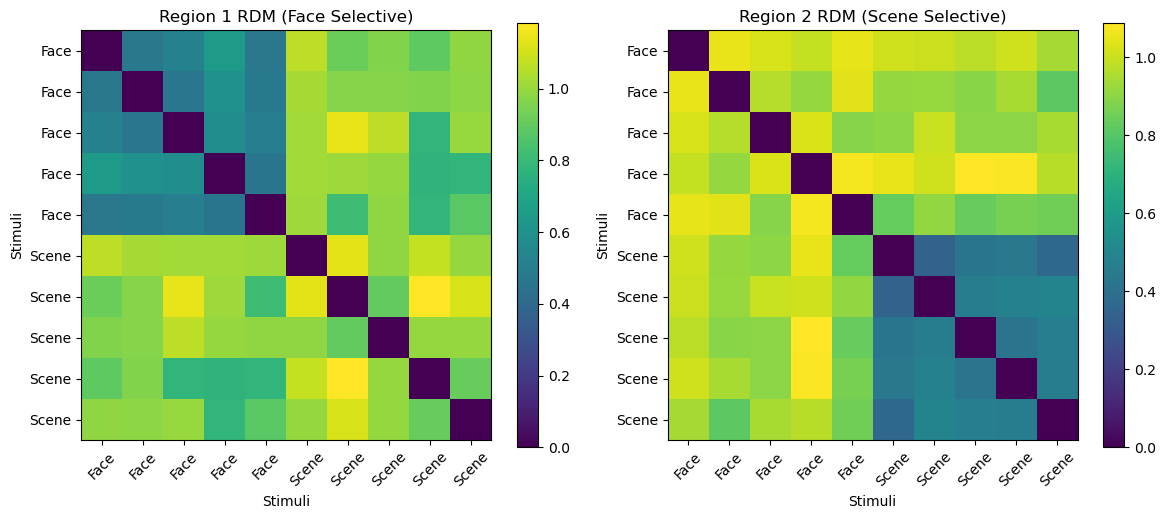

Spearman correlation between RDMs of Region 1 and Region 2:
rho = -0.423, p = 0.004


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

# Set random seed for reproducibility
np.random.seed(44)

# -------------------------------
# Parameters and Setup
# -------------------------------
n_conditions = 10     # 10 conditions: first 5 faces, last 5 scenes
n_voxels = 100        # Number of voxels per region
n_faces = 5
n_scenes = 5
noise_std = 1.0       # Standard deviation for noise

# -------------------------------
# Simulate Base Signals
# -------------------------------
# For region 1, we'll simulate a consistent "face" pattern.
face_signal = np.random.randn(n_voxels)

# For region 2, we'll simulate a consistent "scene" pattern.
scene_signal = np.random.randn(n_voxels)

# -------------------------------
# Create Simulated Data
# -------------------------------
# Region 1: Face selective
# - Faces: signal + noise
# - Scenes: noise only
region1_data = np.zeros((n_conditions, n_voxels))
for i in range(n_faces):  # Conditions 0-4: Faces
    region1_data[i, :] = face_signal + noise_std * np.random.randn(n_voxels)
for i in range(n_faces, n_conditions):  # Conditions 5-9: Scenes
    region1_data[i, :] = noise_std * np.random.randn(n_voxels)

# Region 2: Scene selective
# - Faces: noise only
# - Scenes: signal + noise
region2_data = np.zeros((n_conditions, n_voxels))
for i in range(n_faces):  # Conditions 0-4: Faces
    region2_data[i, :] = noise_std * np.random.randn(n_voxels)
for i in range(n_faces, n_conditions):  # Conditions 5-9: Scenes
    region2_data[i, :] = scene_signal + noise_std * np.random.randn(n_voxels)

# -------------------------------
# Compute Representational Dissimilarity Matrices (RDMs)
# -------------------------------
# We use the correlation distance (i.e., 1 - Pearson correlation) as our metric.
rdm_region1 = squareform(pdist(region1_data, metric='correlation'))
rdm_region2 = squareform(pdist(region2_data, metric='correlation'))

# -------------------------------
# Visualize the RDMs
# -------------------------------
plt.figure(figsize=(12, 5))

# Labels for conditions: "Face" for first 5 and "Scene" for last 5.
labels = ["Face"] * n_faces + ["Scene"] * n_scenes

# Region 1 RDM
plt.subplot(1, 2, 1)
plt.imshow(rdm_region1, interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.title("Region 1 RDM (Face Selective)")
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
plt.xticks(np.arange(n_conditions), labels, rotation=45)
plt.yticks(np.arange(n_conditions), labels)

# Region 2 RDM
plt.subplot(1, 2, 2)
plt.imshow(rdm_region2, interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.title("Region 2 RDM (Scene Selective)")
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
plt.xticks(np.arange(n_conditions), labels, rotation=45)
plt.yticks(np.arange(n_conditions), labels)

plt.tight_layout()
plt.show()

# -------------------------------
# Compare the RDMs
# -------------------------------
# Extract the upper-triangular parts (excluding the diagonal) of the RDMs.
triu_indices = np.triu_indices(n_conditions, k=1)
rdm_region1_vec = rdm_region1[triu_indices]
rdm_region2_vec = rdm_region2[triu_indices]

# Compute Spearman correlation between the two RDM vectors.
rho, pval = spearmanr(rdm_region1_vec, rdm_region2_vec)
print("Spearman correlation between RDMs of Region 1 and Region 2:")
print(f"rho = {rho:.3f}, p = {pval:.3f}")

## Functional connectivity analysis demo

## Prerequsite: install the Activity Flow Toolbox (https://github.com/ColeLab/ActflowToolbox)

### Cole-Anticevic Network Partition
#### A network partition based on fMRI resting-state data, using Pearson correlation functional connectivity and a network community detection algorithm
#### Used for this example: https://github.com/ColeLab/ColeAnticevicNetPartition
#### Citation: [Ji JL*, Spronk M*, Kulkarni K, Repovs G, Anticevic A**, Cole MW** (2019). "Mapping the human brain's cortical-subcortical functional network organization". NeuroImage. 185:35–57. doi:10.1016/j.neuroimage.2018.10.006 (* = equal contribution; ** = senior authors)](https://www.colelab.org/pubs/2018_NeuroImage_JiSpronk.pdf)
![Cole-Anticevic Network Partition](CABNP_cortex.png)

In [16]:
#Import packages and set variables

import numpy as np
import h5py
import pkg_resources
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
sys.path.insert(0, '../../')

#Used for plotting brain images inline
from wbplot import pscalar
import matplotlib.image as mpimg

%matplotlib inline
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = 6,4
plt.rcParams.update({'font.size': 16})
plt.rcParams['image.aspect'] = 'equal'
plt.rcParams['image.cmap'] = 'seismic'

import ActflowToolbox as actflow

actflow_example_dir = pkg_resources.resource_filename('ActflowToolbox.examples', 'HCP_example_data/')

networkpartition_dir = pkg_resources.resource_filename('ActflowToolbox.dependencies', 'ColeAnticevicNetPartition/')
networkdef = np.loadtxt(networkpartition_dir + '/cortex_parcel_network_assignments.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
netorder=networkorder[:,0]
orderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)


subjNums = ['100206','108020','117930','126325','133928','143224','153934','164636','174437',
            '183034','194443','204521','212823','268749','322224','385450','463040','529953',
            '587664','656253','731140','814548','877269','978578','100408','108222','118124',
            '126426','134021','144832']
numsubjs=np.shape(subjNums)[0]
numnodes=360
numtimepoints=1195

taskConditions = ['EMOTION:fear','EMOTION:neut','GAMBLING:win','GAMBLING:loss','LANGUAGE:story','LANGUAGE:math',
                  'MOTOR:cue','MOTOR:lf','MOTOR:rf','MOTOR:lh','MOTOR:rh','MOTOR:t','REASONING:rel',
                  'REASONING:match','SOCIAL:mental','SOCIAL:rnd','WM 0bk:body','WM 0bk:faces','WM 0bk:places',
                  'WM 0bk:tools','WM 2bk:body','WM 2bk:faces','WM 2bk:places','WM 2bk:tools']


/Users/mwcole/Library/CloudStorage/OneDrive-RutgersUniversity/Teaching/Foundations 4/Foundations 4 2025/ClassificationClass/ActflowToolbox/connectivity_estimation/partial_corrconn.py:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if estimator is 'LedoitWolf':
/Users/mwcole/Library/CloudStorage/OneDrive-RutgersUniversity/Teaching/Foundations 4/Foundations 4 2025/ClassificationClass/ActflowToolbox/connectivity_estimation/partial_corrconn.py:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif estimator is 'EmpiricalCovariance':


In [17]:
#Load data
#Data from: https://www.humanconnectome.org/study/hcp-young-adult
#Preprocessed as described here: https://doi.org/10.1101/560730

#Load resting-state fMRI data; 30 HCP subjects, one run of resting-state fMRI each
restdata=np.zeros((numnodes,numtimepoints,numsubjs))
scount = 0
for subj in subjNums:
    file_path=actflow_example_dir + 'HCP_example_restrun1_subj' + subj + '_data' + '.h5'
    h5f = h5py.File(file_path,'r')
    dataid = 'restdata'
    restdata[:,:,scount] = h5f[dataid][:]
    h5f.close()
    scount += 1

#Load task GLM activations; 30 HCP subjects, 24 task conditions
file_path=actflow_example_dir + 'HCP_example_taskactivations_data' + '.h5'
h5f = h5py.File(file_path,'r')
dataid = 'taskbeta'
activations_bycond = h5f[dataid][:]
h5f.close()


## The current field-standard FC measure (but with clear issues for causal interpretation)

In [19]:
%%time
#Run activity flow mapping with Pearson correlation FC
restFC_corr=np.zeros((numnodes,numnodes,numsubjs))
scount=0
for subj in subjNums:
    restFC_corr[:,:,scount]=actflow.connectivity_estimation.corrcoefconn(restdata[:,:,scount])
    scount += 1


CPU times: user 3.57 s, sys: 805 ms, total: 4.38 s
Wall time: 451 ms


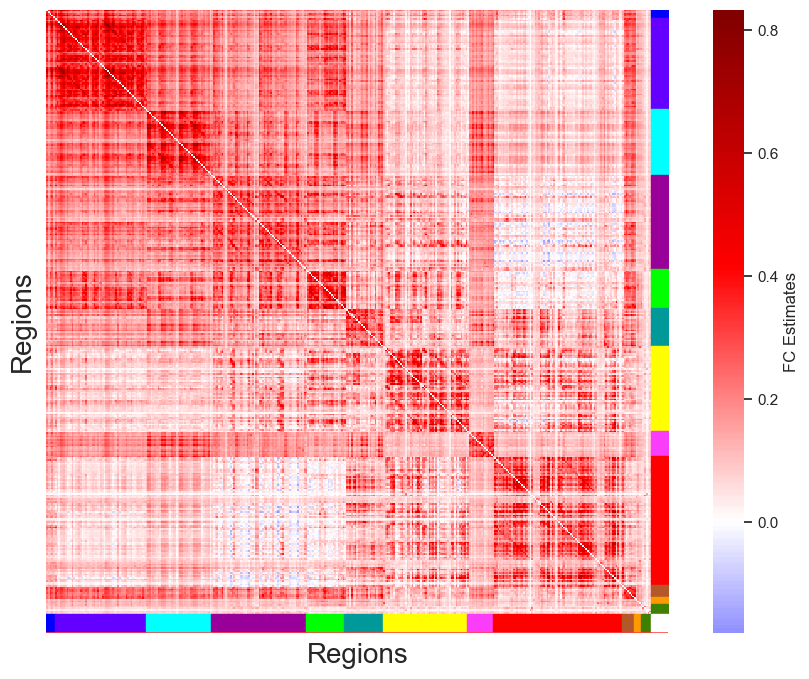

In [20]:
#Visualize FC matrix
fcmat=np.mean(restFC_corr[netorder,:,:][:,netorder,:],axis=2)
fig=actflow.tools.addNetColors_Seaborn(fcmat)

## Partial correlation functional connectivity

### See for more info: [Peterson KL, Sanchez-Romero R, Mill RD, Cole MW (Preprint). "Regularized partial correlation provides reliable functional connectivity estimates while correcting for widespread confounding". bioRxiv. https://doi.org/10.1101/2023.09.16.558065](https://doi.org/10.1101/2023.09.16.558065)

Processing time note: It took 3.75 hours to estimate glasso FC (with cross-validation) for 30 subjects on a 2020 MacBook Pro laptop

In [ ]:
%%time
#Estimate glasso FC (a form of regularized partial correlation), using cross-validation to estimate the L1 regularization parameter
restFC_glassoFC=np.zeros((numnodes,numnodes,numsubjs))
scount=0
for subj in subjNums:
    glassoFC_output=actflow.connectivity_estimation.graphicalLassoCV(restdata[:,:,scount])
    restFC_glassoFC[:,:,scount]=glassoFC_output[0]
    scount += 1


In [ ]:
#Visualize FC matrix
print('Group-average FC matrix')
fcmat_glasso=np.mean(restFC_glassoFC[netorder,:,:][:,netorder,:],axis=2)
fig=actflow.tools.addNetColors_Seaborn(fcmat_glasso)

In [ ]:
#Stats on FC matrices
FCdensities=np.zeros(numsubjs)
scount=0
for subj in subjNums:
    numNodes=np.shape(restFC_glassoFC)[0]
    FCdensities[scount]=np.sum(np.abs(restFC_glassoFC[:,:,scount])>0)/(numNodes*(numNodes-1))*100
    scount += 1

print('FC densities (100 X total # of non-zero connections / total possible connections):')
print('Mean:',np.mean(FCdensities),'%')
print('Stdev:',np.std(FCdensities),'%')
print('Range:',np.min(FCdensities),'% to',np.max(FCdensities),'%')